In [1]:
import h5py
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from src.HBTReader import HBTReader

/cosma/local/Python/2.7.3/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
snap = 40
reader = HBTReader("./data/GR_b64n512/subcat/")
haloes = reader.LoadHostHalos(snap)
haloes = haloes[haloes['M200Crit'] >= 20]

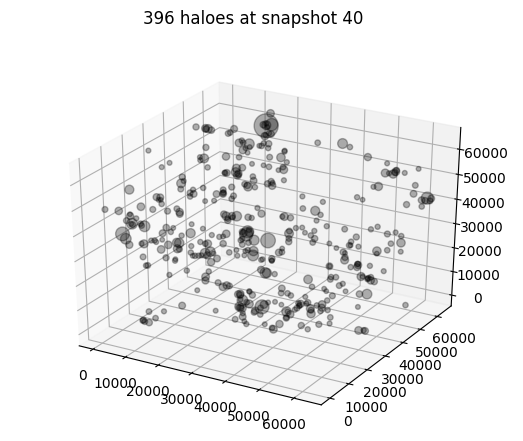

In [3]:
fig, ax = plt.subplots(1, subplot_kw={'projection': '3d'})
fig.suptitle("%d haloes at snapshot %d" % (len(haloes), snap))

ax.scatter(
    *haloes['CenterComoving'].T,
    s=300*(haloes['M200Crit'] / haloes['M200Crit'].max()),
    c='k', alpha=0.3
)

In [4]:
def nearest_neighbour(halo, f=1.0, n=0):
    """n-th neighbour more massive then f*M (M of halo h).
    
    .. todo::

        Error handling for small numbers of haloes!

    """
    
    if halo['M200Crit'] == haloes['M200Crit'].max():
        r = np.nan

    else:
        _haloes = haloes[
            (haloes['HaloId'] != halo['HaloId']) &
            (haloes['M200Crit'] >= f*halo['M200Crit'])
        ]

        r = pd.DataFrame({
            'm': _haloes['M200Crit'] / halo['M200Crit'],
            'r': np.sqrt(np.sum(
                    np.power(
                        halo['CenterComoving'] -
                        _haloes['CenterComoving'], 2.0),
                    axis=1
                ))
        }).sort_values('r').iloc[n]['r'] / halo['R200CritComoving']

    return r

In [5]:
def spherical_overdensity(halo, r=5):
    """(Over)density within radius ``r`` of halo center.
    """
    return 0.0

def shell_overdensity(halo, r_min=1, r=5):
    """(Over)density within shell between ``r_min`` and ``r``.
    """
    return 0.0

In [6]:
def experienced_potential(halo):
    """Experienced gravity for a halo.
    """
    c = halo['NFW_c']
    r_s = nfw.r_s(c)
    delta_c = nfw.delta_c(c)

    rs = np.linspace(-2.0, 0.0, 100)
    phi = [phi(r) for r in rs]

    phi_star = phi + 4*np.pi*G*delta_c * cosmology.rho_crit(halo['snap']) * \
        np.div((r_s * r_s * r_s), rs) * np.log(1.0 + rs / r_s)

    return np.mean(phi_star)

In [7]:
def plot3d(xs, ys, zs, ss, cs):
    ix = ~np.isnan(cs)
    xs, ys, zs, ss, cs = xs[ix], ys[ix], zs[ix], ss[ix], cs[ix]

    scalarMap = matplotlib.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs)),
        cmap=plt.get_cmap('viridis')
    )
    scalarMap.set_array(cs)
    fig, ax = plt.subplots(1, figsize=[9, 7], subplot_kw={'projection': '3d'})
    fig.suptitle("%d haloes at snapshot %d, N=1, f=1.0" % (len(haloes), snap))
    fig.colorbar(scalarMap).ax.set_ylabel(r"$D_{N, f}$", rotation=270)
    ax.set_xlabel(r"$x$"); ax.set_xticklabels([])
    ax.set_ylabel(r"$y$"); ax.set_yticklabels([])
    ax.set_zlabel(r"$z$"); ax.set_zticklabels([])
    ax.scatter(xs, ys, zs, s=ss, c=scalarMap.to_rgba(cs))
    fig.tight_layout()
    
    return fig, ax

In [8]:
nearest_neighbours = np.array([nearest_neighbour(halo) for halo in tqdm(haloes)])

100%|██████████| 396/396 [00:00<00:00, 837.12it/s]


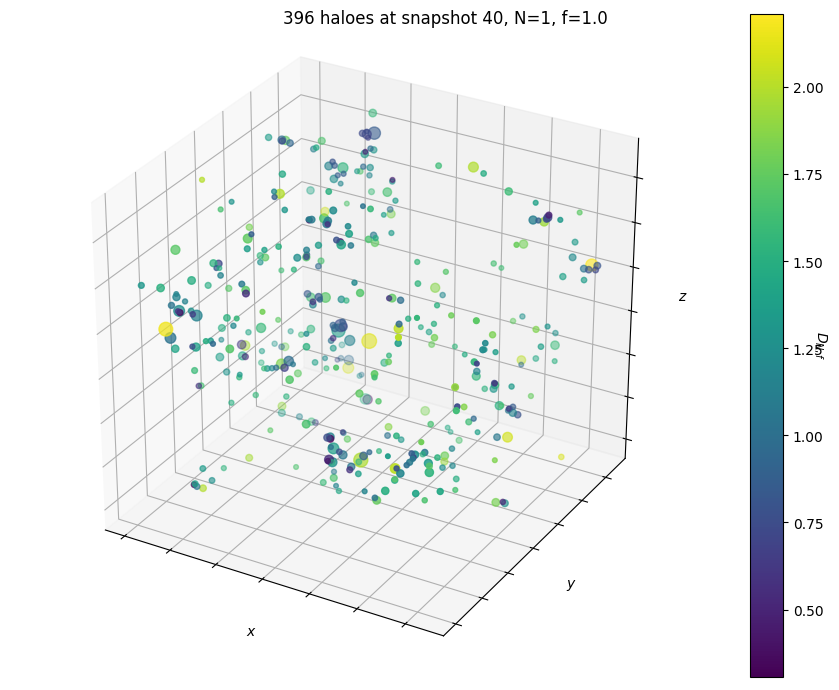

In [9]:
fig, ax = plot3d(
    *haloes['CenterComoving'].T,
    ss=300*(haloes['M200Crit'] / haloes['M200Crit'].max()),
    cs=np.log10(nearest_neighbours)
)

# fig.savefig("./3d.pdf")

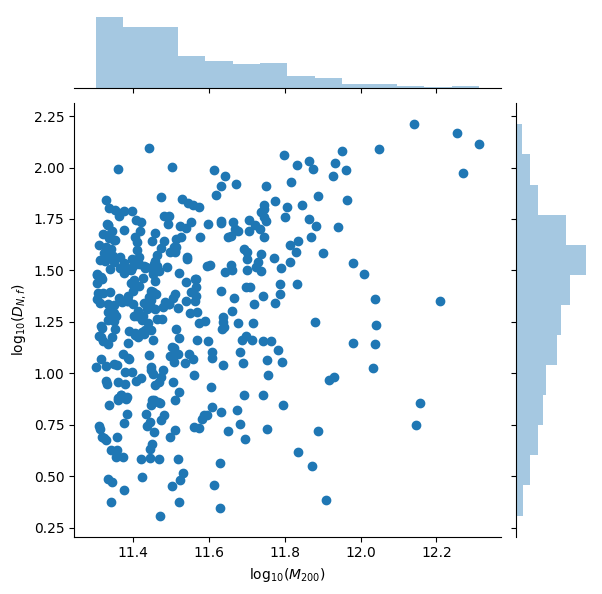

In [10]:
p = sns.jointplot(x="m", y="d", data=pd.DataFrame({
    'm': np.log10(1e10*haloes['M200Crit']),
    'd': np.log10(nearest_neighbours)
}), stat_func=None)

p.set_axis_labels(r"$\log_{10}(M_{200})$", r"$\log_{10}(D_{N,f})$")